<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/Band_Structure_Data_Extraction_and_Regeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before performing the script below, be sure to upload the image or experimental data to the notebook folder and replace the path link where applicable.
_________________________________________________________________
The following plots are an attempt at extracting data points from an image or screenshot of a bandstructure.

In [ ]:
# Example image path is: /content/Graphene Band Structure Data.png

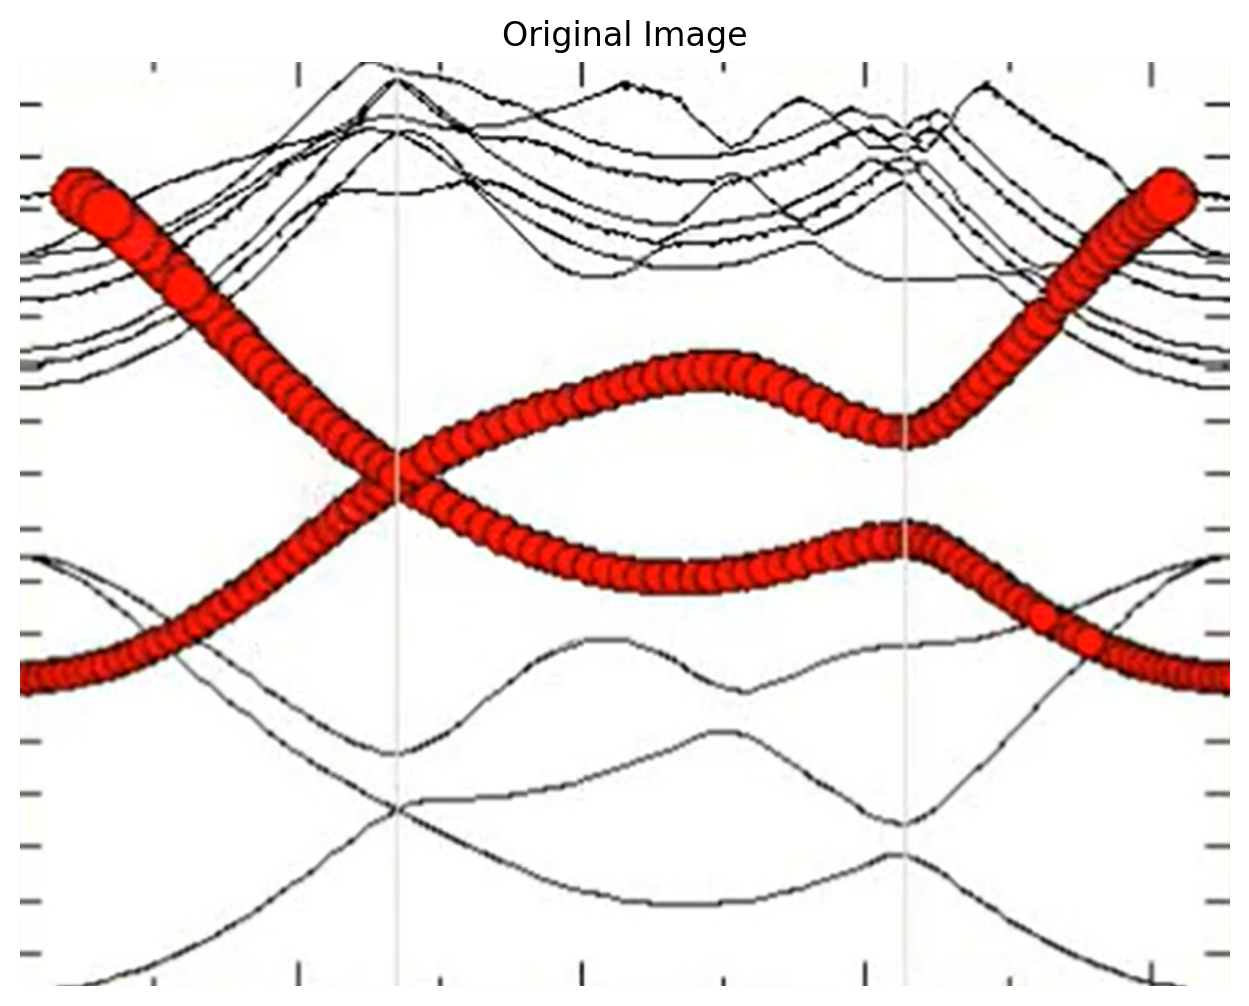

Average Colors (RGB):
[[101.22727273 100.45454545  99.86363636]
 [175.56       174.36       169.72      ]
 [154.73076923 154.11538462 152.84615385]
 ...
 [152.61781285 148.45659526 146.21871477]
 [173.078125   170.625      171.5625    ]
 [180.75       178.35714286 178.78571429]]


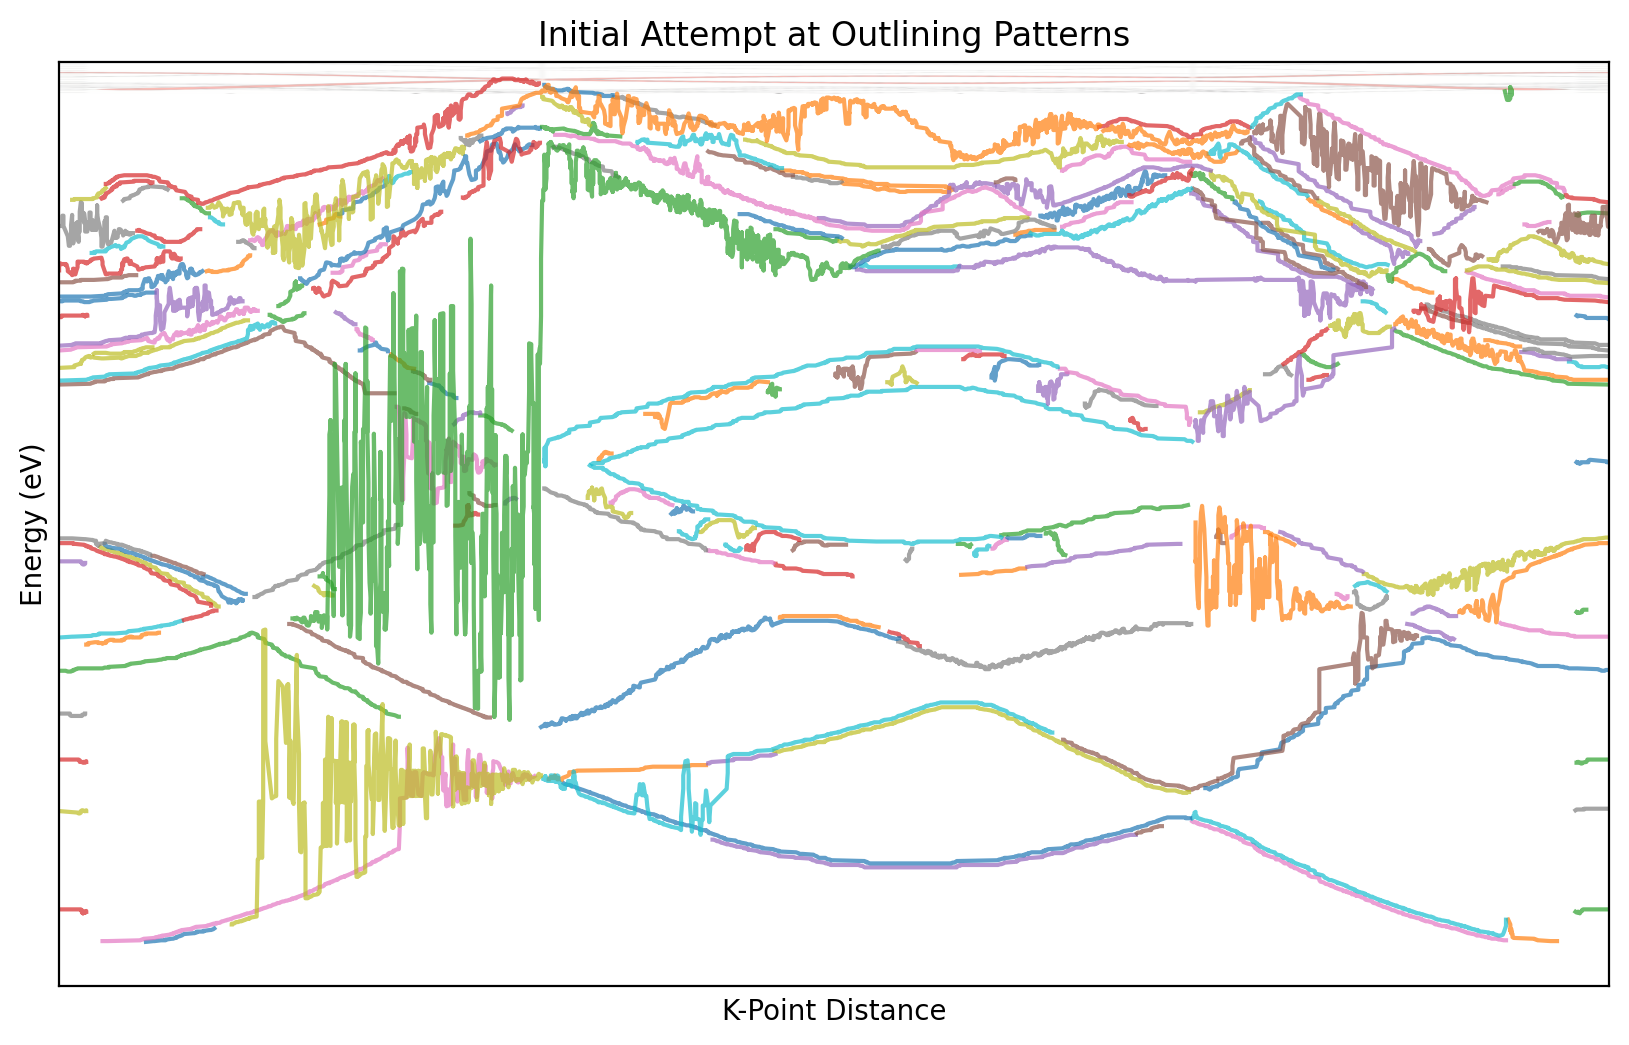

In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

# Load the image
image_path = "/content/Graphene Band Structure Data.png"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect edges to isolate rough lines
edges = cv2.Canny(gray_image, threshold1=50, threshold2=150)

# Find contours to identify line patterns
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for line extraction
line_mask = np.zeros_like(gray_image)

# Draw the contours onto the mask
for contour in contours:
    cv2.drawContours(line_mask, [contour], -1, 255, thickness=1)

# Extract line data from the image
line_data = cv2.bitwise_and(image_rgb, image_rgb, mask=line_mask)

# Isolate average color for each pattern (rough red or black lines)
line_colors = []
valid_contours = []

for contour in contours:
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, [contour], -1, 255, thickness=-1)
    mean_color = cv2.mean(image_rgb, mask=mask)
    line_colors.append(mean_color[:3])  # Ignore alpha if present

    # Filter out "weird trajectories" (e.g., very short lines or erratic shapes)
    if len(contour) > 20:  # Keep only contours with sufficient points
        valid_contours.append(contour)

# Average color analysis
avg_colors = np.array(line_colors)
print("Average Colors (RGB):")
print(avg_colors)

# Fit valid line patterns using a moving average
fitted_lines = []

for contour in valid_contours:
    ys = [point[0][1] for point in contour]
    xs = [point[0][0] for point in contour]

    # Sort and clean up trajectory
    ys_sorted_indices = np.argsort(xs)
    xs = np.array(xs)[ys_sorted_indices]
    ys = np.array(ys)[ys_sorted_indices]

    # Detect and remove outliers using a local variance threshold
    deltas = np.diff(ys, prepend=ys[0])
    std_dev = np.std(deltas)
    mask = np.abs(deltas) < 2 * std_dev  # Keep points with reasonable changes
    xs = xs[mask]
    ys = ys[mask]

    # Apply a moving average to smooth the data
    smoothed_ys = uniform_filter1d(ys, size=5)
    fitted_lines.append((xs, smoothed_ys))

# Plot the cleaned and smoothed lines
plt.figure(figsize=(10, 6))
plt.imshow(image_rgb, alpha=0.3, extent=[0, 1, -20, 20], aspect="auto")
plt.gca().invert_yaxis()

for i, (xs, ys) in enumerate(fitted_lines):
    plt.plot(xs / line_mask.shape[1], ys, label=f"Line {i+1}", alpha=0.7)

plt.title("Initial Attempt at Outlining Patterns")
plt.xlabel("K-Point Distance")
plt.ylabel("Energy (eV)")

# Remove tick marks and labels
plt.tick_params(axis='both', which='both', length=0)  # Hides tick marks on both axes
plt.xticks([])  # Removes x-axis tick labels
plt.yticks([])  # Removes y-axis tick labels

# plt.legend()
plt.grid(False)
plt.show()


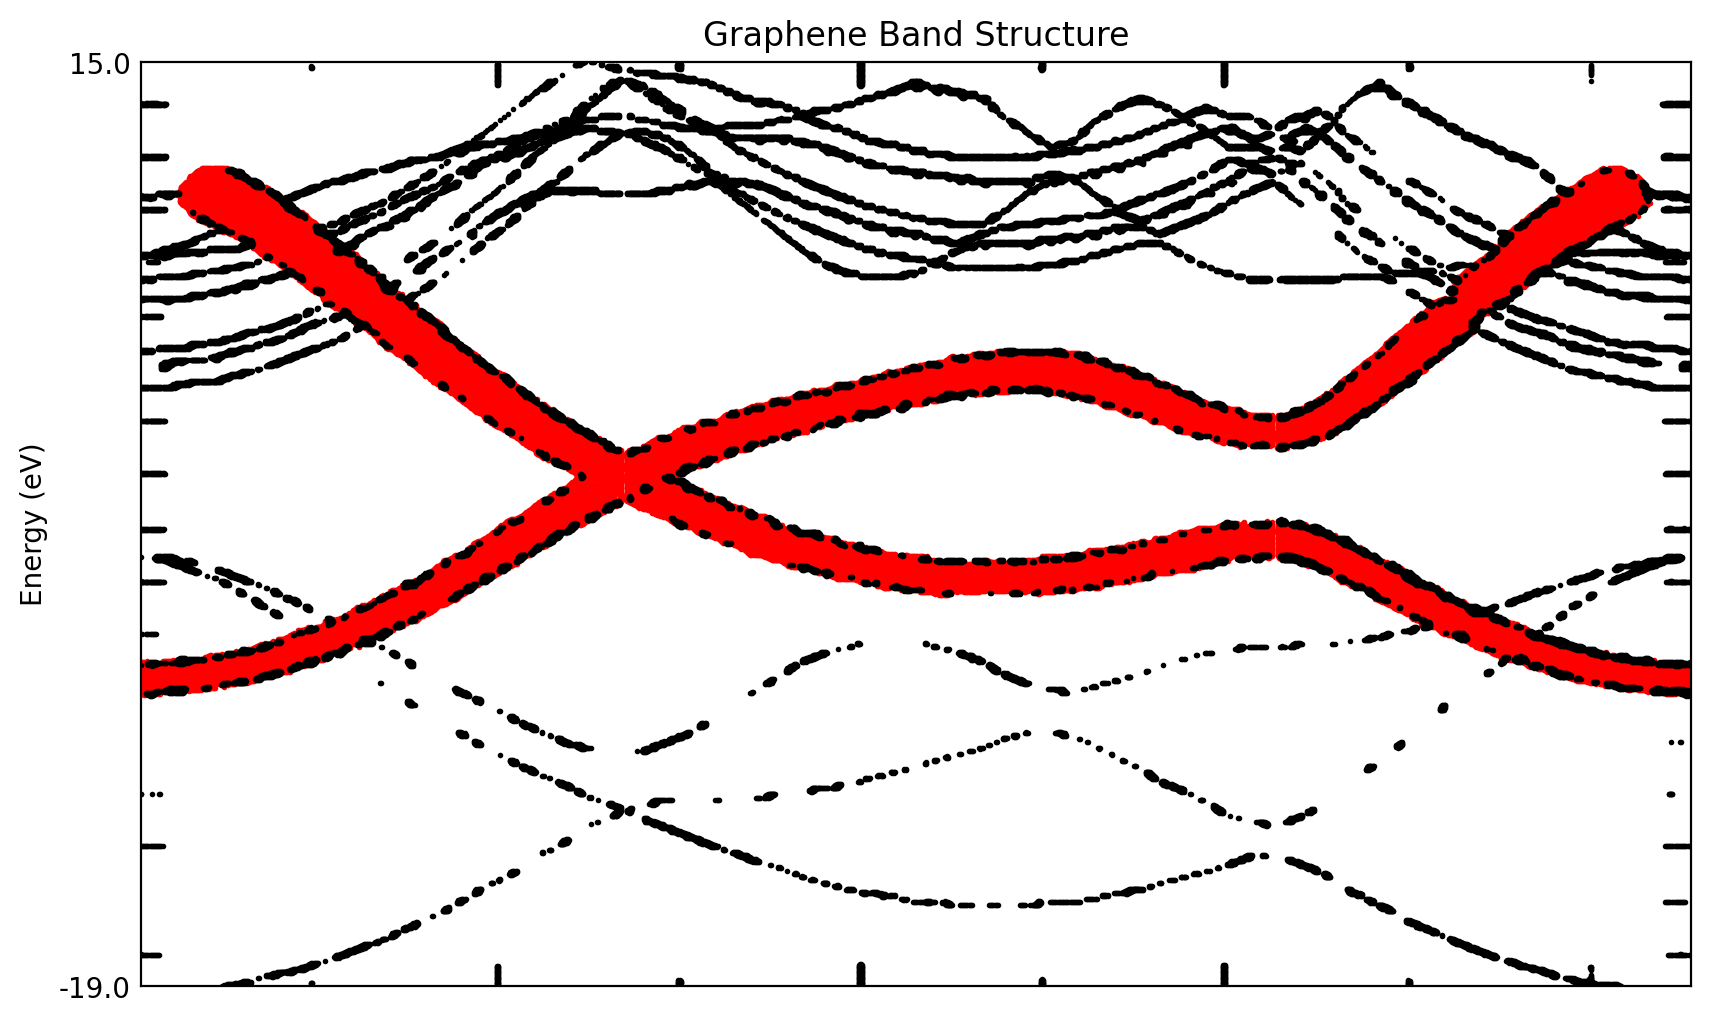

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image_path = "/content/Graphene Band Structure Data.png"
image = cv2.imread(image_path)

# Convert the image to grayscale for line extraction
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use edge detection to identify lines
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Use Hough Line Transform to extract line-like features
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)

# Separate red and black patterns
red_mask = cv2.inRange(image, (0, 0, 128), (100, 100, 255))  # Red color range
black_mask = cv2.inRange(image, (0, 0, 0), (100, 100, 100))  # Black color range

red_lines = cv2.bitwise_and(image, image, mask=red_mask)
black_lines = cv2.bitwise_and(image, image, mask=black_mask)

# Extract x and y coordinates of red and black patterns
red_points = np.column_stack(np.where(red_mask > 0))
black_points = np.column_stack(np.where(black_mask > 0))

# Convert image coordinates to graph coordinates
# Assuming axes are provided (K-Point Distance for x-axis, Energy (eV) for y-axis)
height, width, _ = image.shape
kpoint_distance = np.linspace(0, 1, width)  # Assuming normalized x-axis
energy = np.linspace(-10, 10, height)  # Original y-axis range

red_coords = [(kpoint_distance[x] - 0.3, energy[height - y - 1]) for y, x in red_points]
black_coords = [(kpoint_distance[x] - 0.3, energy[height - y - 1]) for y, x in black_points]

# Plotting
plt.figure(figsize=(10, 6))

# Original data points
plt.scatter(*zip(*red_coords), color="red", s=1, label="Red Lines")
plt.scatter(*zip(*black_coords), color="black", s=1, label="Black Lines")

# Remove x-axis labels and tick values
plt.xlabel("")
plt.xticks([])

# Rename y-axis ticks to range from -19 to 15 eV
num_y_ticks = 2  # Number of y-ticks (adjust as needed)
new_y_ticks = np.linspace(-19, 15, num_y_ticks)  # New range for y-ticks
plt.yticks(ticks=np.linspace(-10, 10, num_y_ticks), labels=[f"{tick:.1f}" for tick in new_y_ticks])

plt.ylabel("Energy (eV)")
plt.xlabel("K-Point Distance")
plt.title("Graphene Band Structure")
plt.xlim(-0.3, 0.7)

# Set y-axis limits
plt.ylim(-10, 10)  # Keep the original data limits

# Remove tick marks
plt.tick_params(axis='both', which='both', length=0)  # Hides tick marks on both axes

# Remove grid lines
plt.grid(False)

plt.show()